In [1]:
import zdb
import glob
import os
import oyaml as yaml

In [2]:
help(zdb.modules.analyse)

Help on function analyse in module zdb.modules.analyse:

analyse(config, mode='multiprocesing', ncores=0, nfiles=-1, batch_opts='', output=None, chunksize=500000, merge_opts={})



In [3]:
def generate_yaml(hists, selection, filepath, tables={"central": "Events"}, systs=[], mc=False):
    hists_def = {
        "_".join(k): [
            {"table": "df: '{table_name}'"},
            {"varname0": "df: '{}'".format(k[0])},
            {"varname1": "df: '{}'".format(k[1])},
            {"varname2": "df: '{}'".format(k[2])},
            {"selection": "df: '{selection_name}'"},
            {"parent": "df: df.parent"},
            {"binvar0": "df: df.{}_bin".format(k[0])},
            {"binvar1": "df: df.{}_bin".format(k[1])},
            {"binvar2": "df: df.{}_bin".format(k[2])},
            {"count": "df: 1."},
            {"sum_w": "df: {weight}"},
            {"sum_ww": "df: df.sum_w**2"},
        ] for k in hists
    }
    
    if mc:
        for key, hdef in hists_def.items():
            for label, vari in systs:
                hdef.extend([
                    {"sum_w_{}".format(label): "df: df.sum_w*({})".format(vari)},
                    {"sum_ww_{}".format(label): "df: (df.sum_w*({}))**2".format(vari)},
                ])
    
    monojet_selection = selection + ["METTriggered", "MinDPhiJ1234METnoX>0.5"]
    monojetqcd_selection = selection + ["METTriggered", "MinDPhiJ1234METnoX<=0.5"]
    singlemuon_selection = selection + ["METTriggered", "MinDPhiJ1234METnoX>0.5", "nMuonSelection==1", "MTW>30.", "MTW<125."]
    singlemuonplus_selection = selection + ["METTriggered", "MinDPhiJ1234METnoX>0.5", "nMuonSelection==1", "MTW>30.", "MTW<125.", "LeptonCharge>0."]
    singlemuonminus_selection = selection + ["METTriggered", "MinDPhiJ1234METnoX>0.5", "nMuonSelection==1", "MTW>30.", "MTW<125.", "LeptonCharge<0."]
    singlemuonqcd_selection = selection + ["METTriggered", "MinDPhiJ1234METnoX<=0.5", "nMuonSelection==1", "MTW>30.", "MTW<125."]
    doublemuon_selection = selection + ["METTriggered", "MinDPhiJ1234METnoX>0.5", "nMuonSelection==2", "MLL>71.", "MLL<111.", "LeptonCharge==0."]
    doublemuonqcd_selection = selection + ["METTriggered", "MinDPhiJ1234METnoX<=0.5", "nMuonSelection==2", "MLL>71.", "MLL<111.", "LeptonCharge==0."]
    singleelectron_selection = selection + ["SingleElectronTriggered", "MinDPhiJ1234METnoX>0.5", "nElectronSelection==1", "MTW>30.", "MTW<125.", "MET_pt>100."]
    singleelectronplus_selection = selection + ["SingleElectronTriggered", "MinDPhiJ1234METnoX>0.5", "nElectronSelection==1", "MTW>30.", "MTW<125.", "MET_pt>100.", "LeptonCharge>0."]
    singleelectronminus_selection = selection + ["SingleElectronTriggered", "MinDPhiJ1234METnoX>0.5", "nElectronSelection==1", "MTW>30.", "MTW<125.", "MET_pt>100.", "LeptonCharge<0."]
    singleelectronqcd_selection = selection + ["SingleElectronTriggered", "MinDPhiJ1234METnoX<=0.5", "nElectronSelection==1", "MTW>30.", "MTW<125.", "MET_pt>100."]
    doubleelectron_selection = selection + ["SingleElectronTriggered", "MinDPhiJ1234METnoX>0.5", "nElectronSelection==2", "MLL>71.", "MLL<111.", "LeptonCharge==0."]
    doubleelectronqcd_selection = selection + ["SingleElectronTriggered", "MinDPhiJ1234METnoX<=0.5", "nElectronSelection==2", "MLL>71.", "MLL<111.", "LeptonCharge==0."]
    singletau_selection = selection + ["METTriggered", "MinDPhiJ1234METnoX>0.5", "nTauSelection==1"]
    singlemuonmu_selection = selection + ["SingleMuonTriggered", "MinDPhiJ1234METnoX>0.5", "nMuonSelection==1", "MTW>30.", "MTW<125."]
    singlemuonmuqcd_selection = selection + ["SingleMuonTriggered", "MinDPhiJ1234METnoX<=0.5", "nMuonSelection==1", "MTW>30.", "MTW<125."]
    doublemuonmu_selection = selection + ["SingleMuonTriggered", "MinDPhiJ1234METnoX>0.5", "nMuonSelection==2", "MLL>71.", "MLL<111.", "LeptonCharge==0."]
    doublemuonmuqcd_selection = selection + ["SingleMuonTriggered", "MinDPhiJ1234METnoX<=0.5", "nMuonSelection==2", "MLL>71.", "MLL<111.", "LeptonCharge==0."]
    if not mc:
        monojet_selection.extend(["nMuonVeto==0", "nElectronVeto==0", "nTauVeto==0"])
        monojetqcd_selection.extend(["nMuonVeto==0", "nElectronVeto==0", "nTauVeto==0"])
        singlemuon_selection.extend(["nMuonVeto==1", "nElectronVeto==0", "nTauVeto==0"])
        singlemuonqcd_selection.extend(["nMuonVeto==1", "nElectronVeto==0", "nTauVeto==0"])
        doublemuon_selection.extend(["nMuonVeto==2", "nElectronVeto==0", "nTauVeto==0"])
        doublemuonqcd_selection.extend(["nMuonVeto==2", "nElectronVeto==0", "nTauVeto==0"])
        singleelectron_selection.extend(["nMuonVeto==0", "nElectronVeto==1", "nTauVeto==0"])
        singleelectronqcd_selection.extend(["nMuonVeto==0", "nElectronVeto==1", "nTauVeto==0"])
        doubleelectron_selection.extend(["nMuonVeto==0", "nElectronVeto==2", "nTauVeto==0"])
        doubleelectronqcd_selection.extend(["nMuonVeto==0", "nElectronVeto==2", "nTauVeto==0"])
        singletau_selection.extend(["nMuonVeto==0", "nElectronVeto==0", "nTauVeto==1"])
        singlemuonmu_selection.extend(["nMuonVeto==1", "nElectronVeto==0", "nTauVeto==0"])
        singlemuonmuqcd_selection.extend(["nMuonVeto==1", "nElectronVeto==0", "nTauVeto==0"])
        doublemuonmu_selection.extend(["nMuonVeto==2", "nElectronVeto==0", "nTauVeto==0"])
        doublemuonmuqcd_selection.extend(["nMuonVeto==2", "nElectronVeto==0", "nTauVeto==0"])

    cutflows = {
        #"Monojet": {
        #    "selection_name": "Monojet",
        #    "selection": "(" + ") & (".join(monojet_selection) + ")",
        #    "weight": "1." if not mc else "df.Weight_Monojet",
        #    "hists": [h for h in hists_def.keys() if not any(test in h or h.startswith("n") for test in [
        #         "MTW", "MLL", "Muon", "Electron", "Tau",
        #    ])],
        #},
        #"MonojetQCD": {
        #    "selection_name": "MonojetQCD",
        #    "selection": "(" + ") & (".join(monojetqcd_selection) + ")",
        #    "weight": "1." if not mc else "df.Weight_MonojetQCD",
        #    "hists": [h for h in hists_def.keys() if not any(test in h or h.startswith("n") for test in [
        #         "MTW", "MLL", "Muon", "Electron", "Tau",
        #    ])],
        #},
        "SingleMuon": {
            "selection_name": "SingleMuon",
            "selection": "(" + ") & (".join(singlemuon_selection) + ")",
            "weight": "1." if not mc else "df.Weight_SingleMuon",
            "hists": [h for h in hists_def.keys() if not any(test in h or h.startswith("n") for test in [
                "MLL", "SecondMuon", "Electron", "Tau",
            ])],
        },
        #"SingleMuonPlus": {
        #    "selection_name": "SingleMuonPlus",
        #    "selection": "(" + ") & (".join(singlemuonplus_selection) + ")",
        #    "weight": "1." if not mc else "df.Weight_SingleMuonPlus",
        #    "hists": [h for h in hists_def.keys() if not any(test in h or h.startswith("n") for test in [
        #        "MLL", "SecondMuon", "Electron", "Tau",
        #    ])],
        #},
        #"SingleMuonMinus": {
        #    "selection_name": "SingleMuonMinus",
        #    "selection": "(" + ") & (".join(singlemuonminus_selection) + ")",
        #    "weight": "1." if not mc else "df.Weight_SingleMuonMinus",
        #    "hists": [h for h in hists_def.keys() if not any(test in h or h.startswith("n") for test in [
        #        "MLL", "SecondMuon", "Electron", "Tau",
        #    ])],
        #},
        #"SingleMuonQCD": {
        #    "selection_name": "SingleMuonQCD",
        #    "selection": "(" + ") & (".join(singlemuonqcd_selection) + ")",
        #    "weight": "1." if not mc else "df.Weight_SingleMuonQCD",
        #    "hists": [h for h in hists_def.keys() if not any(test in h or h.startswith("n") for test in [
        #        "MLL", "SecondMuon", "Electron", "Tau",
        #    ])],
        #},
        #"DoubleMuon": {
        #    "selection_name": "DoubleMuon",
        #    "selection": "(" + ") & (".join(doublemuon_selection) + ")",
        #    "weight": "1." if not mc else "df.Weight_DoubleMuon",
        #    "hists": [h for h in hists_def.keys() if not any(test in h or h.startswith("n") for test in [
        #        "MTW", "Electron", "Tau",
        #    ])],
        #},
        "SingleElectron": {
            "selection_name": "SingleElectron",
            "selection": "(" + ") & (".join(singleelectron_selection) + ")",
            "weight": "1." if not mc else "df.Weight_SingleElectron",
            "hists": [h for h in hists_def.keys() if not any(test in h or h.startswith("n") for test in [
                "MLL", "SecondElectron", "Muon", "Tau",
            ])],
        },
        #"SingleElectronPlus": {
        #    "selection_name": "SingleElectronPlus",
        #    "selection": "(" + ") & (".join(singleelectronplus_selection) + ")",
        #    "weight": "1." if not mc else "df.Weight_SingleElectronPlus",
        #    "hists": [h for h in hists_def.keys() if not any(test in h or h.startswith("n") for test in [
        #        "MLL", "SecondElectron", "Muon", "Tau",
        #    ])],
        #},
        #"SingleElectronMinus": {
        #    "selection_name": "SingleElectronMinus",
        #    "selection": "(" + ") & (".join(singleelectronminus_selection) + ")",
        #    "weight": "1." if not mc else "df.Weight_SingleElectronMinus",
        #    "hists": [h for h in hists_def.keys() if not any(test in h or h.startswith("n") for test in [
        #        "MLL", "SecondElectron", "Muon", "Tau",
        #    ])],
        #},
        #"SingleElectronQCD": {
        #    "selection_name": "SingleElectronQCD",
        #    "selection": "(" + ") & (".join(singleelectronqcd_selection) + ")",
        #    "weight": "1." if not mc else "df.Weight_SingleElectronQCD",
        #    "hists": [h for h in hists_def.keys() if not any(test in h or h.startswith("n") for test in [
        #        "MLL", "SecondElectron", "Muon", "Tau",
        #    ])],
        #},
        #"DoubleElectron": {
        #    "selection_name": "DoubleElectron",
        #    "selection": "(" + ") & (".join(doubleelectron_selection) + ")",
        #    "weight": "1." if not mc else "df.Weight_DoubleElectron",
        #    "hists": [h for h in hists_def.keys() if not any(test in h or h.startswith("n") for test in [
        #        "MTW", "Muon", "Tau",
        #    ])],
        #},
        #"SingleTau": {
        #    "selection_name": "SingleTau",
        #    "selection": "(" + ") & (".join(singletau_selection) + ")",
        #    "weight": "1." if not mc else "df.Weight_SingleTau",
        #    "hists": [h for h in hists_def.keys() if not any(test in h or h.startswith("n") for test in [
        #        "MTW", "MLL", "Muon", "Electron",
        #    ])],
        #},
        #"SingleMuonMu": {
        #    "selection_name": "SingleMuonMu",
        #    "selection": "(" + ") & (".join(singlemuonmu_selection) + ")",
        #    "weight": "1." if not mc else "df.Weight_SingleMuonMu",
        #    "hists": [h for h in hists_def.keys() if not any(test in h or h.startswith("n") for test in [
        #        "MLL", "SecondMuon", "Electron", "Tau",
        #    ])],
        #},
        #"SingleMuonMuQCD": {
        #    "selection_name": "SingleMuonMuQCD",
        #    "selection": "(" + ") & (".join(singlemuonmuqcd_selection) + ")",
        #    "weight": "1." if not mc else "df.Weight_SingleMuonMuQCD",
        #    "hists": [h for h in hists_def.keys() if not any(test in h or h.startswith("n") for test in [
        #        "MLL", "SecondMuon", "Electron", "Tau",
        #    ])],
        #},
        #"DoubleMuonMu": {
        #    "selection_name": "DoubleMuonMu",
        #    "selection": "(" + ") & (".join(doublemuonmu_selection) + ")",
        #    "weight": "1." if not mc else "df.Weight_DoubleMuonMu",
        #    "hists": [h for h in hists_def.keys() if not any(test in h or h.startswith("n") for test in [
        #        "MTW", "Electron", "Tau",
        #    ])],
        #},
    }

    met_triggers = [
        "df.HLT_PFMETNoMu90_PFMHTNoMu90_IDTight",
        "df.HLT_PFMETNoMu100_PFMHTNoMu100_IDTight",
        "df.HLT_PFMETNoMu110_PFMHTNoMu110_IDTight",
        "df.HLT_PFMETNoMu120_PFMHTNoMu120_IDTight",
        "(df.HLT_PFMET170_NotCleaned & (df.run<276282))",
        "(df.HLT_PFMET170_BeamHaloCleaned & (df.run<276282))",
        "df.HLT_PFMET170_HBHECleaned",
        "df.HLT_PFMET170_HBHE_BeamHaloCleaned",
        "df.HLT_MET75_IsoTrk50",
    ]
    if mc:
        met_triggers = [
            "df.HLT_PFMETNoMu90_PFMHTNoMu90_IDTight",
            "df.HLT_PFMETNoMu100_PFMHTNoMu100_IDTight",
            "df.HLT_PFMETNoMu110_PFMHTNoMu110_IDTight",
            "df.HLT_PFMETNoMu120_PFMHTNoMu120_IDTight",
            "df.HLT_PFMET170_NotCleaned",
            "df.HLT_PFMET170_BeamHaloCleaned",
            "df.HLT_PFMET170_HBHECleaned",
            "df.HLT_PFMET170_HBHE_BeamHaloCleaned",
            "df.HLT_MET75_IsoTrk50",
        ]
        
    singlemuon_triggers = ["df.HLT_IsoMu24", "df.HLT_IsoTkMu24"]
    singleelectron_triggers = [
        "df.HLT_Ele27_WPTight_Gsf",
        "df.HLT_Ele115_CaloIdVT_GsfTrkIdT",
    ]

    cfg_eval_bins = [
        {"METnoX_pt_bin": "df: np.floor(df.METnoX_pt/5.)*5."},
        {"Generator_id1_bin": "df: np.floor(df.Generator_id1/1.)*1."},
        {"Generator_id2_bin": "df: np.floor(df.Generator_id2/1.)*1."},
    ]
    
    if mc:
        weight = [
            "df.WeightXsLumi",
            "df.WeightQcdEwk",
            "df.WeightPU",
            "df.WeightPreFiring",
            "df.WeightOneMinusPhotonVetoIdLoose",
            "df.WeightOneMinusPhotonVetoPixelSeedVeto",
            "df.WeightOneMinusJetBVetoIdMedium",
        ]
        weight_ele_veto = [
            "df.WeightOneMinusElectronVetoNoSelectionIdIsoVeto",
            "df.WeightOneMinusElectronSelectionIdIsoTight",
            "df.WeightOneMinusElectronVetoReco",
        ]
        weight_ele_sele = [
            "df.WeightElectronSelectionIdIsoTight",
            "df.WeightElectronSelectionReco",
            "df.WeightOneMinusElectronVetoNoSelectionIdIsoVeto",
            "df.WeightOneMinusElectronVetoNoSelectionReco",
        ]
        weight_mu_veto = [
            "df.WeightOneMinusMuonVetoNoSelectionIdLoose",
            "df.WeightOneMinusMuonVetoNoSelectionIsoLoose",
            "df.WeightOneMinusMuonSelectionIdTight",
            "df.WeightOneMinusMuonSelectionIsoTight",
        ]
        weight_mu_sele = [
            "df.WeightMuonSelectionIdTight",
            "df.WeightMuonSelectionIsoTight",
            "df.WeightOneMinusMuonVetoNoSelectionIdLoose",
            "df.WeightOneMinusMuonVetoNoSelectionIsoLoose",
        ]
        weight_tau_veto = [
            "df.WeightOneMinusTauSelectionIdTight",
            "df.WeightOneMinusTauVetoNoSelectionIdVLoose",
        ]
        weight_tau_sele = [
            "df.WeightTauSelectionIdTight",
            "df.WeightOneMinusTauVetoNoSelectionIdVLoose",
        ]
        weight_met_trig = ["df.WeightMETTrig",]
        weight_singleele_trig = ["df.WeightSingleElectronTrig"]
        weight_singlemu_trig = ["df.WeightSingleMuonTrig"]
        
        cfg_eval_bins.extend([
            {"parent": "df: np.where( df.parent.isin(['WJetsToLNu', 'DYJetsToLL']), np.where( df.parent=='WJetsToLNu', np.where( df.LeptonCharge>0, np.where( df.LeptonIsElectron, np.full_like(df.parent, 'WJetsToEPlusNu'), np.where( df.LeptonIsMuon, np.full_like(df.parent, 'WJetsToMuPlusNu'), np.where( df.LeptonIsTau, np.where( df.nGenTauL==0, np.full_like(df.parent, 'WJetsToTauHPlusNu'), np.where( df.nGenTauL==1, np.full_like(df.parent, 'WJetsToTauLPlusNu'), np.full_like(df.parent, 'WJetsToTauPlusNu'), ), ), np.full_like(df.parent, 'WJetsToLPlusNu'), ), ), ), np.where( df.LeptonIsElectron, np.full_like(df.parent, 'WJetsToEMinusNu'), np.where( df.LeptonIsMuon, np.full_like(df.parent, 'WJetsToMuMinusNu'), np.where( df.LeptonIsTau, np.where( df.nGenTauL==0, np.full_like(df.parent, 'WJetsToTauHMinusNu'), np.where( df.nGenTauL==1, np.full_like(df.parent, 'WJetsToTauLMinusNu'), np.full_like(df.parent, 'WJetsToTauMinusNu'), ), ), np.full_like(df.parent, 'WJetsToLMinusNu'), ), ), ), ), np.where( df.parent=='DYJetsToLL', np.where(  df.LeptonIsElectron, np.full_like(df.parent, 'DYJetsToEE'), np.where( df.LeptonIsMuon, np.full_like(df.parent, 'DYJetsToMuMu'), np.where( df.LeptonIsTau, np.where( df.nGenTauL==0, np.full_like(df.parent, 'DYJetsToTauHTauH'), np.where( df.nGenTauL==1, np.full_like(df.parent, 'DYJetsToTauHTauL'), np.where( df.nGenTauL==2, np.full_like(df.parent, 'DYJetsToTauLTauL'), np.full_like(df.parent, 'DYJetsToTauTau'), ), ), ), np.full_like(df.parent, 'DYJetsToLL'), ), ), ), df.parent, ), ), df.parent, )"},
            {"Weight_Monojet": "df: (" + ")*(".join(weight+weight_ele_veto+weight_mu_veto+weight_tau_veto+weight_met_trig)+")"},
            {"Weight_MonojetQCD": "df: df.Weight_Monojet"},
            {"Weight_SingleMuon": "df: (" + ")*(".join(weight+weight_ele_veto+weight_mu_sele+weight_tau_veto+weight_met_trig)+")"},
            {"Weight_SingleMuonPlus": "df: df.Weight_SingleMuon"},
            {"Weight_SingleMuonMinus": "df: df.Weight_SingleMuon"},
            {"Weight_SingleMuonQCD": "df: df.Weight_SingleMuon"},
            {"Weight_DoubleMuon": "df: df.Weight_SingleMuon"},
            {"Weight_SingleElectron": "df: (" + ")*(".join(weight+weight_ele_sele+weight_mu_veto+weight_tau_veto+weight_singleele_trig)+")"},
            {"Weight_SingleElectronPlus": "df: df.Weight_SingleElectron"},
            {"Weight_SingleElectronMinus": "df: df.Weight_SingleElectron"},
            {"Weight_SingleElectronQCD": "df: df.Weight_SingleElectron"},
            {"Weight_DoubleElectron": "df: df.Weight_SingleElectron"},
            {"Weight_SingleTau": "df: (" + ")*(".join(weight+weight_ele_veto+weight_mu_veto+weight_tau_sele+weight_met_trig)+")"},
            {"Weight_SingleMuonMu": "df: (" + ")*(".join(weight+weight_ele_veto+weight_mu_sele+weight_tau_veto+weight_singlemu_trig)+")"},
            {"Weight_SingleMuonMuQCD": "df: df.Weight_SingleMuonMu"},
            {"Weight_DoubleMuonMu": "df: df.Weight_SingleMuonMu"},
        ])
        
    cfg_eval_bins.extend([
        {"METTriggered": "df: (" + ") | (".join(met_triggers) + ")"},
        {"SingleMuonTriggered": "df: (" + ") | (".join(singlemuon_triggers) + ")"},
        {"SingleElectronTriggered": "df: (" + ") | (".join(singleelectron_triggers) + ")"},
    ])

    cfg = {
        "query": {
            "groupby": ["table", "varname0", "varname1", "varname2", "selection", "parent", "binvar0", "binvar1", "binvar2"],
            "tables": tables,
            "aliases": {},
            "eval": cfg_eval_bins,
            "cutflows": cutflows,
            "hists": hists_def,
        },
        "files": sorted(p for p in glob.glob(filepath)),
    }
    
    return cfg

In [4]:
hists = [("METnoX_pt", "Generator_id1", "Generator_id2")]
systs = []
data_selection = [
    "IsCertified", "Flag_goodVertices", "Flag_globalSuperTightHalo2016Filter",
    "Flag_HBHENoiseFilter", "Flag_HBHENoiseIsoFilter", "Flag_EcalDeadCellTriggerPrimitiveFilter",
    "Flag_BadPFMuonFilter", "Flag_eeBadScFilter", "MET_dCaloMET<0.5",
    "nJetSelection>0", "nJetSelection==nJetVeto", "LeadJetSelection_chHEF>0.1",
    "LeadJetSelection_neHEF<0.8", "LeadJetSelection_pt>200.", "nPhotonVeto==0",
    "nBJetVeto==0", "METnoX_pt>200."
]
mc_selection = [
    "(parent!='EWKV2Jets' | nGenBosonSelection==1)", "Flag_goodVertices", "Flag_globalSuperTightHalo2016Filter",
    "Flag_HBHENoiseFilter", "Flag_HBHENoiseIsoFilter", "Flag_EcalDeadCellTriggerPrimitiveFilter",
    "Flag_BadPFMuonFilter", "MET_dCaloMET<0.5", "nJetSelection>0",
    "nJetSelection==nJetVeto", "LeadJetSelection_chHEF>0.1", "LeadJetSelection_neHEF<0.8",
    "LeadJetSelection_pt>200.", "METnoX_pt>200.",
]

cfg_mc = generate_yaml(
    hists, mc_selection,
    "/vols/cms/sdb15/Analysis/ZinvWidth/databases/skims/2019/09_Sep/14_skims/mc/*.h5",
    systs=systs,
    mc=True,
)
with open("configs/dists/mc_met_x1_x2.yaml", "w") as f:
    yaml.dump(cfg_mc, f, indent=4)

## Submit

In [5]:
#zdb.modules.multi_analyse(
#    ["configs/hists/mc_inclusive.yaml"],
#    outputs=["dists_inclusive.h5:MCAggEvents"],
#    mode='sge',
#    ncores=400,
#    batch_opts="-q hep.q -l h_rt=3:0:0 -l h_vmem=12G",
#    chunksize=250_000,
#    merge_opts={"mode": "sge", "ncores": 25, "batch_opts": "-q hep.q"},
#)

## Draw

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dftools

plt.style.use("cms")

Welcome to JupyROOT 6.18/00


In [25]:
df = pd.read_hdf("data/hists/dists_met_x1_x2.h5", "MCAggEvents")
df = df.loc[("central", "METnoX_pt", "Generator_id1", "Generator_id2"),:]

df = dftools.transform.merge(
    df, {
        "WJetsToLNu": [
            "WJetsToEPlusNu", "WJetsToEMinusNu", "WJetsToMuPlusNu", "WJetsToMuMinusNu",
            "WJetsToTauLPlusNu", "WJetsToTauLMinusNu", "WJetsToTauHPlusNu", "WJetsToTauHMinusNu",
        ],
    }
)
mask = (
    (df.index.get_level_values("selection").isin(["SingleMuon", "SingleElectron"]))
    & (df.index.get_level_values("parent").isin(["WJetsToLNu"]))
)
df = df.loc[mask, :]
df = dftools.transform.rebin(
    df, np.array([-5, -4, -3, -2, -1, 1, 2, 3, 4, 5, 21]),
    label="binvar1"
)
df = dftools.transform.rebin(
    df, np.array([-5, -4, -3, -2, -1, 1, 2, 3, 4, 5, 21]),
    label="binvar2"
)
#df = df.reset_index(["binvar1", "binvar2"])
#conv = {
#    -5: r'$\bar{b}$', -4: r'$\bar{c}$', -3: r'$\bar{s}$', -2: r'$\bar{u}$', -1: r'$\bar{d}$',
#    1: r'$d$', 2: r'$u$', 3: r'$s$', 4: r'$c$', 5: r'$b$', 21: r'$g$',
#}
#df["binvar1"] = df["binvar1"].map(conv)
#df["binvar2"] = df["binvar2"].map(conv)
#df = df.set_index(["binvar1", "binvar2"], append=True)

In [26]:
df_low = df.loc[df.index.get_level_values("binvar0")<300.,:]
df_high = df.loc[df.index.get_level_values("binvar0")>1400.,:]
df_high.head(5)

count  sum_w  sum_ww
selection      parent     binvar0 binvar1 binvar2                      
SingleElectron WJetsToLNu 1405.0  -5      -5         0.0    0.0     0.0
                                          -4         0.0    0.0     0.0
                                          -3         0.0    0.0     0.0
                                          -2         0.0    0.0     0.0
                                          -1         0.0    0.0     0.0

In [31]:
conv = {
    -5: r'$\bar{b}$', -4: r'$\bar{c}$', -3: r'$\bar{s}$', -2: r'$\bar{u}$', -1: r'$\bar{d}$',
    1: r'$d$', 2: r'$u$', 3: r'$s$', 4: r'$c$', 5: r'$b$', 21: r'$g$',
}

['$\\bar{b}$', '$\\bar{c}$', '$\\bar{s}$', '$\\bar{u}$', '$\\bar{d}$', '$d$', '$u$', '$s$', '$c$', '$b$', '$g$']
['$\\bar{b}$', '$\\bar{c}$', '$\\bar{s}$', '$\\bar{u}$', '$\\bar{d}$', '$d$', '$u$', '$s$', '$c$', '$b$', '$g$']


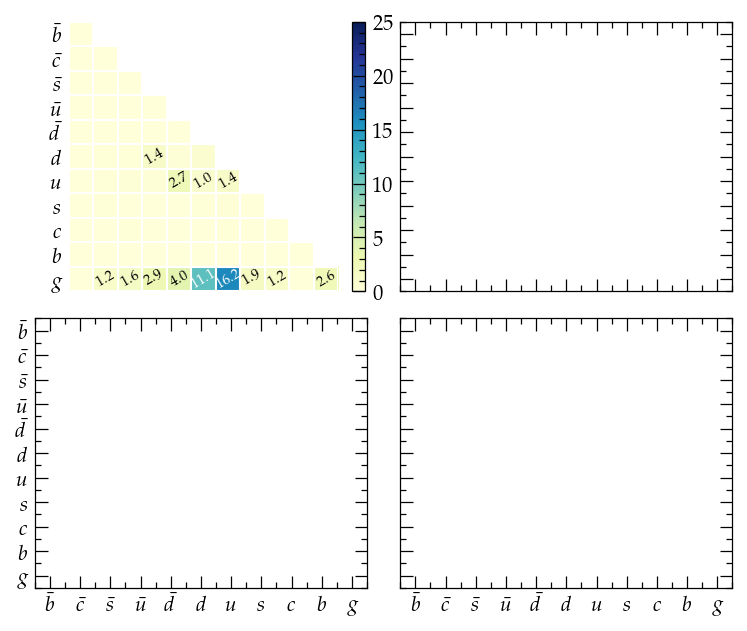

In [100]:
tdf = df_low.loc[("SingleMuon", "WJetsToLNu"),"sum_w"].groupby(["binvar1", "binvar2"]).sum()
tdf = (tdf/tdf.sum()).unstack().fillna(0.)
x = [conv[v] for v in tdf.index.get_level_values("binvar1").values]
y = [conv[v] for v in tdf.columns.values]
z = tdf.values*100
print(x)
print(y)

for i in range(z.shape[0]):
    for j in range(z.shape[1]):
        if i < j:
            z[i,j] = np.nan

fig, ax = plt.subplots(
    figsize=(6, 5), dpi=150,
    nrows=2, ncols=2,
    sharex=True, sharey=True,
    gridspec_kw={"hspace": 0.1, "wspace": 0.1},
)

im, bar = dftools.draw.heatmap(
    z, y, x, ax[0,0], cmap="YlGnBu",
    cbarlabel=r'',
    grid_kw={"linewidth": 1},
)
dftools.draw.annotate_heatmap(
    im, data=z, valfmt='{x:.1f}',
    textcolors=['black', 'white'],
    cthreshold=lambda z: z>10.,
    vthreshold=lambda z: z>1.,
    fontsize=7, rotation=30,
)
bar.mappable.set_clim(0., 25.)
pass

In [101]:
tdf = df_high.loc[("SingleMuon", "WJetsToLNu"),"sum_w"].groupby(["binvar1", "binvar2"]).sum()
tdf = (tdf/tdf.sum()).unstack().fillna(0.)
x = [conv[v] for v in tdf.index.get_level_values("binvar1").values]
y = [conv[v] for v in tdf.columns.values]
z = tdf.values*100
print(x)
print(y)

for i in range(z.shape[0]):
    for j in range(z.shape[1]):
        if i < j:
            z[i,j] = np.nan

im, bar = dftools.draw.heatmap(
    z, y, x, ax[0,1], cmap="YlGnBu",
    cbarlabel=r'Percentage',
    grid_kw={"linewidth": 1},
)
dftools.draw.annotate_heatmap(
    im, data=z, valfmt='{x:.1f}',
    textcolors=['black', 'white'],
    cthreshold=lambda z: z>10.,
    vthreshold=lambda z: z>1.,
    fontsize=7, rotation=30,
)
bar.mappable.set_clim(0., 25.)
bar.set_label(r'Percentage', va="bottom")
pass

['$\\bar{b}$', '$\\bar{c}$', '$\\bar{s}$', '$\\bar{u}$', '$\\bar{d}$', '$d$', '$u$', '$s$', '$c$', '$b$', '$g$']
['$\\bar{b}$', '$\\bar{c}$', '$\\bar{s}$', '$\\bar{u}$', '$\\bar{d}$', '$d$', '$u$', '$s$', '$c$', '$b$', '$g$']


In [102]:
tdf = df_low.loc[("SingleElectron", "WJetsToLNu"),"sum_w"].groupby(["binvar1", "binvar2"]).sum()
tdf = (tdf/tdf.sum()).unstack().fillna(0.)
x = [conv[v] for v in tdf.index.get_level_values("binvar1").values]
y = [conv[v] for v in tdf.columns.values]
z = tdf.values*100
print(x)
print(y)

for i in range(z.shape[0]):
    for j in range(z.shape[1]):
        if i < j:
            z[i,j] = np.nan

im, bar = dftools.draw.heatmap(
    z, y, x, ax[1,0], cmap="YlGnBu",
    cbarlabel=r'',
    grid_kw={"linewidth": 1},
)
dftools.draw.annotate_heatmap(
    im, data=z, valfmt='{x:.1f}',
    textcolors=['black', 'white'],
    cthreshold=lambda z: z>10.,
    vthreshold=lambda z: z>1.,
    fontsize=7, rotation=30,
)
bar.mappable.set_clim(0., 25.)
pass

['$\\bar{b}$', '$\\bar{c}$', '$\\bar{s}$', '$\\bar{u}$', '$\\bar{d}$', '$d$', '$u$', '$s$', '$c$', '$b$', '$g$']
['$\\bar{b}$', '$\\bar{c}$', '$\\bar{s}$', '$\\bar{u}$', '$\\bar{d}$', '$d$', '$u$', '$s$', '$c$', '$b$', '$g$']


In [103]:
tdf = df_high.loc[("SingleElectron", "WJetsToLNu"),"sum_w"].groupby(["binvar1", "binvar2"]).sum()
tdf = (tdf/tdf.sum()).unstack().fillna(0.)
x = [conv[v] for v in tdf.index.get_level_values("binvar1").values]
y = [conv[v] for v in tdf.columns.values]
z = tdf.values*100
print(x)
print(y)

for i in range(z.shape[0]):
    for j in range(z.shape[1]):
        if i < j:
            z[i,j] = np.nan

im, bar = dftools.draw.heatmap(
    z, y, x, ax[1,1], cmap="YlGnBu",
    cbarlabel=r'Percentage',
    grid_kw={"linewidth": 1},
)
dftools.draw.annotate_heatmap(
    im, data=z, valfmt='{x:.1f}',
    textcolors=['black', 'white'],
    cthreshold=lambda z: z>10.,
    vthreshold=lambda z: z>1.,
    fontsize=7, rotation=30,
)
bar.mappable.set_clim(0., 25.)
bar.set_label(r'Percentage', va='bottom')
pass

['$\\bar{b}$', '$\\bar{c}$', '$\\bar{s}$', '$\\bar{u}$', '$\\bar{d}$', '$d$', '$u$', '$s$', '$c$', '$b$', '$g$']
['$\\bar{b}$', '$\\bar{c}$', '$\\bar{s}$', '$\\bar{u}$', '$\\bar{d}$', '$d$', '$u$', '$s$', '$c$', '$b$', '$g$']


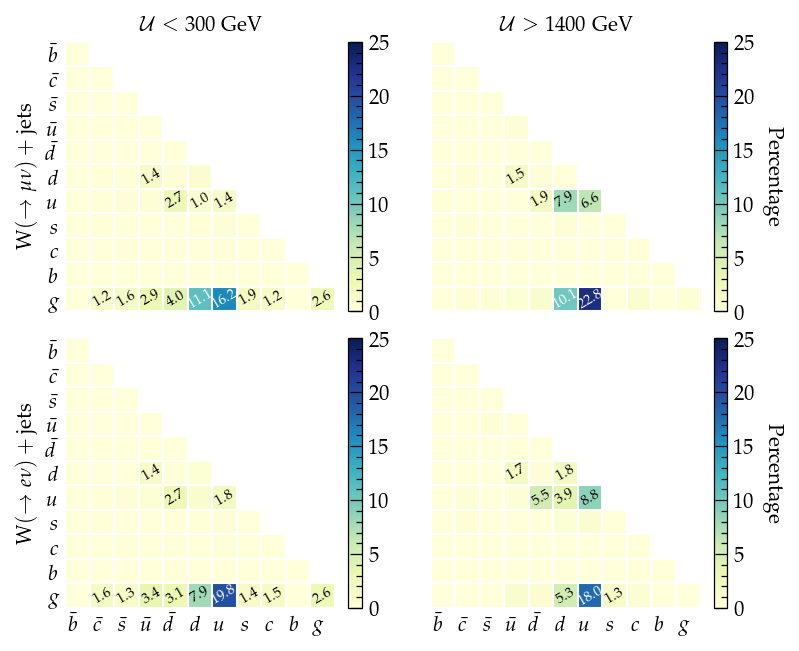

In [104]:
ax[0,0].set_ylabel(r'$\mathrm{W}(\rightarrow\mu\nu)+\mathrm{jets}$', rotation=90)
ax[1,0].set_ylabel(r'$\mathrm{W}(\rightarrow e\nu)+\mathrm{jets}$', rotation=90)
ax[0,0].set_title(r'$\mathcal{U}<300$ GeV', fontsize=10)
ax[0,1].set_title(r'$\mathcal{U}>1400$ GeV', fontsize=10)
fig